**KMeans Clustering on Twitter :** Alberto Arostegui, David Elorza Gabilondo, Unai Bermúdez -> 06/10/2023

**Descripción:**  ...

**Importar los datos**
Vamos a usar la libreria de pandas para importar los datos del csv y convertirlos en un data frame con el que podamos trabajar.

In [2]:
import pandas as pd
import numpy as np

# the dataset have already been split into train, test set
train  = pd.read_csv("suicidal_data.csv",sep=",", encoding='cp1252')

In [3]:
# Mapear los valores en la columna 'label'
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9206 entries, 0 to 9205
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   9206 non-null   int64 
 1   tweet   9206 non-null   object
dtypes: int64(1), object(1)
memory usage: 144.0+ KB


In [4]:
#Para hacernos una idea son los mensajes en función de la clase:
train[(train['label']==0)].head(5)

,label,tweet
3325,0,i wish i got to watch it with you i miss you ...
3326,0,i want to go to promote gear and groove but u...
3327,0,oh manwas ironing fave top to wear to a meetin...
3328,0,sadly though i ve never gotten to experience t...
3329,0,wonders why someone that u like so much can ma...


In [5]:
train[(train['label']==1)].head(5)

,label,tweet
0,1,my life is meaningless i just want to end my l...
1,1,muttering i wanna die to myself daily for a fe...
2,1,work slave i really feel like my only purpose ...
3,1,i did something on the 2 of october i overdose...
4,1,i feel like no one cares i just want to die ma...


**Análisis de Datos  :** Para hacernos una idea de como es el conjunto de datos vamos a tratar de ver cuantas instancias hay por clase con gráficos, si hay valores faltantes...

In [6]:
print('Dataset size:',train.shape)
print('columns are:',train.columns)

Dataset size: (9206, 2)
columns are: Index(['label', 'tweet'], dtype='object')


Text(0.5, 1.0, 'Barplot del conjunto train')

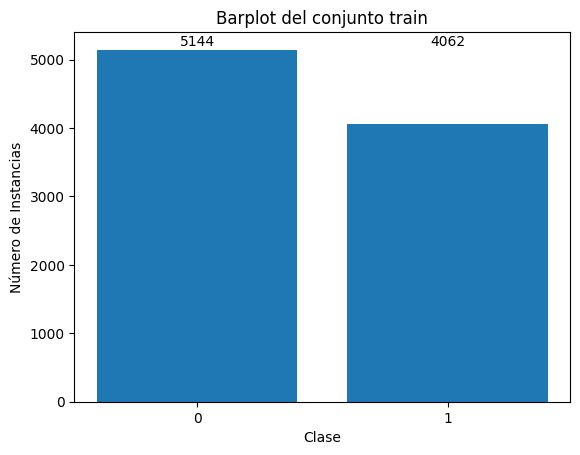

In [7]:
#Si queremos hacernos una idea de cuantas instancias hay por clase, podemos graficarlo mediante este barplot, mediante la libería matplotlib:
import matplotlib.pyplot as plt
y_train = train['label'].copy()
value_counts = y_train.value_counts()
sorted_counts = value_counts.sort_index(ascending=True)
sorted_labels = sorted_counts.index
max_count = sorted_counts.max()
# Crear el gráfico de barras
plt.bar(sorted_labels, sorted_counts)
label_height = max_count + 10
for index, value in enumerate(sorted_counts):
    plt.text(index, label_height, str(value), ha='center', va='bottom')
plt.xticks(range(len(sorted_labels)), sorted_labels)
plt.xlabel('Clase')
plt.ylabel('Número de Instancias')
plt.title('Barplot del conjunto train')

In [8]:
print("Las instancias están repartidas en las dos clases de la siguiente forma:")
print(train['label'].value_counts(), end="\n")

Las instancias están repartidas en las dos clases de la siguiente forma:
label
0    5144
1    4062
Name: count, dtype: int64


Para ver cuantos valores faltantes tenemos

In [9]:
# Check for missing values in the DataFrame
missing_values = train.isnull().sum()

# Display the number of missing values for each column
print("Missing Values in the DataFrame:")
print(missing_values)

Missing Values in the DataFrame:
label    0
tweet    0
dtype: int64


Si queremos a ver si hay instancias repetidas:

In [10]:
# Check for duplicated instances
duplicated_instances = train.duplicated().sum()
print("Instancias duplicadas:", duplicated_instances)

Instancias duplicadas: 327


Rango de atributos:

In [11]:
# Range of values for each attribute
attribute_ranges = train.describe()
print("Rango de valores de los atributos:")
print(attribute_ranges)

Rango de valores de los atributos:
             label
count  9206.000000
mean      0.441234
std       0.496562
min       0.000000
25%       0.000000
50%       0.000000
75%       1.000000
max       1.000000


****Preproceso :**** Para que los tweets tengan la información más relevante vamos a aplicar un preproceso de tal forma que se quiten signos de puntuación, mayúsuculas, stopwords y vamos a lematizar las palabras para que nos den toda la misma información.

In [12]:
import re
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)

    return input_txt

print('Dataset size:',train.shape)
print('columns are:',train.columns)

Dataset size: (9206, 2)
columns are: Index(['label', 'tweet'], dtype='object')


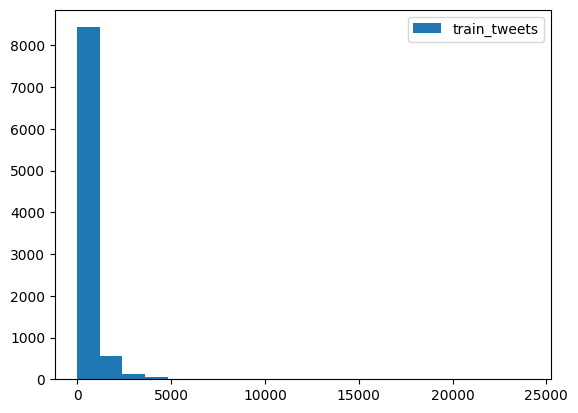

In [13]:
length_train = train['tweet'].str.len()

plt.hist(length_train, bins=20, label="train_tweets")
plt.legend()
plt.show()

* Se van a quitar los @ de usuario:

In [14]:
train['tidy_tweet'] = np.vectorize(remove_pattern)(train['tweet'], "@[\w]*")

* Se van a remplazar mayúsuclas por minúsculas:

In [15]:
train['tidy_tweet'] = train['tidy_tweet'].str.replace("[^a-zA-Z#]", " ")

* Se juntas las palabras separadas

In [16]:
train['tidy_tweet'] = train['tidy_tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))

* Tokenizacion

In [17]:
tokenized_tweet = train['tidy_tweet'].apply(lambda x: x.split())
tokenized_tweet.head()

0    [life, meaningless, just, want, end, life, bad...
1    [muttering, wanna, die, myself, daily, for, fe...
2    [work, slave, really, feel, like, only, purpos...
3    [did, something, the, october, overdosed, just...
4    [feel, like, one, cares, just, want, die, mayb...
Name: tidy_tweet, dtype: object

* Se stematizan las palabras

In [18]:
from nltk.stem.porter import *
stemmer = PorterStemmer()

tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x]) # stemming
tokenized_tweet.head()
for i in range(len(tokenized_tweet)):
    tokenized_tweet[i] = ' '.join(tokenized_tweet[i])

train['tidy_tweet'] = tokenized_tweet

* Se borran las stopwords

In [19]:
import nltk.corpus

stopword = nltk.corpus.stopwords.words('english')
stopword.extend(['fuck', 'shit'])

In [20]:
def remove_stopwords(text):
  text = [word for word in text if word not in stopword]
  return text

# combi['tidy_tweet'] = combi['tidy_tweet'].apply(lambda x: remove_stopwords(x)) # stemming
# combi.head()

* Y con esto obtenemos ya los tweets preprocesados:

In [21]:
train['tidy_tweet'] = train['tidy_tweet'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopword)]))

#visualize all the words our data using the wordcloud plot
all_words = ' '.join([text for text in train['tidy_tweet']])

** Palabras representtivas **

* Con esto podemos observar las palabras que más se repiten en general en los tweets:

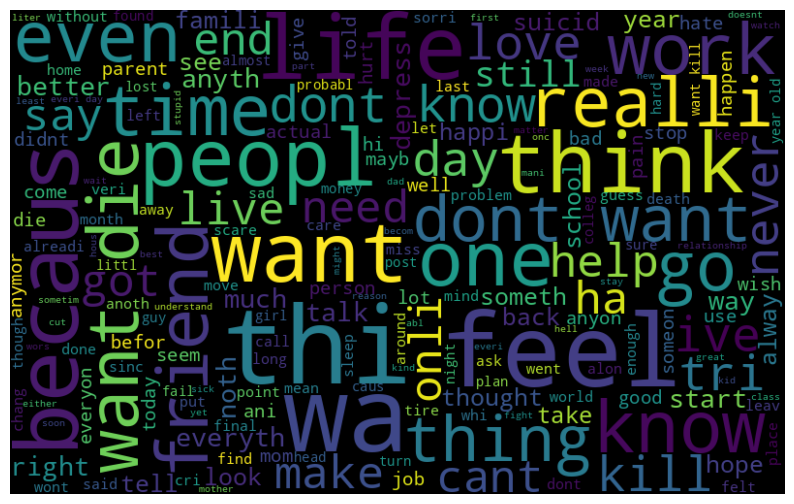

In [22]:
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

* Con esto podemos observar las palabras que más se repiten en los tweets con label si:

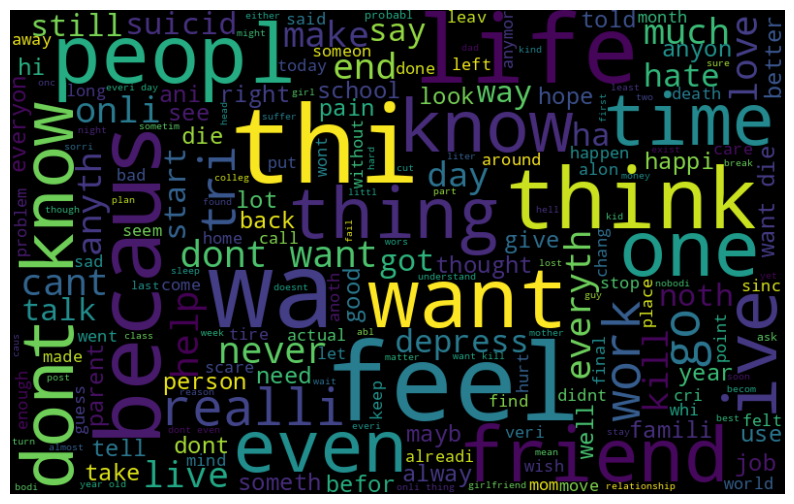

In [23]:
#Suicide
negative_words = ' '.join([text for text in train['tidy_tweet'][train['label'] == 1]])
wordcloud = WordCloud(width=800, height=500,
random_state=21, max_font_size=110).generate(negative_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

* Con esto podemos observar las palabras que más se repiten en los tweets con label no:

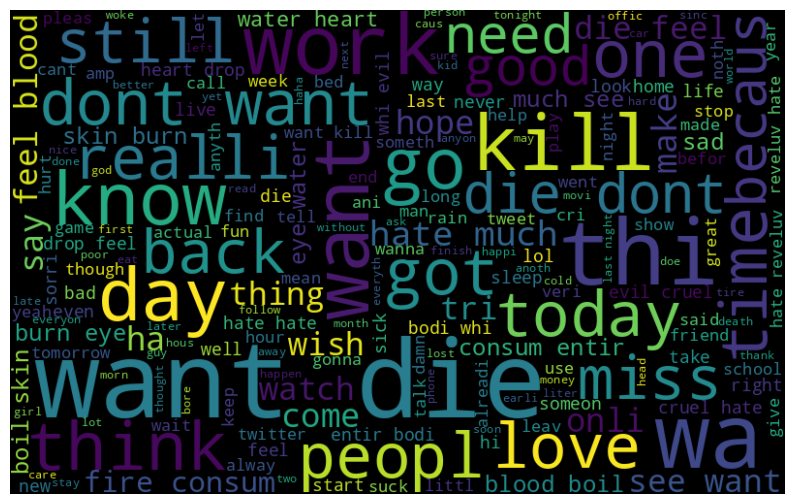

In [24]:
#Non-suicide
normal_words =' '.join([text for text in train['tidy_tweet'][train['label'] == 0]])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(normal_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

**Vectorizacin**

* BOW (Bag of Words)

In [25]:
#Bag-of-words
from sklearn.feature_extraction.text import CountVectorizer
bow_vectorizer = CountVectorizer(max_df=0.90, min_df=2, max_features=20000, stop_words='english')
# bag-of-words feature matrix
bow = bow_vectorizer.fit_transform(train['tidy_tweet'])
bow.shape
# bow[:5]

(9206, 7400)

* TF-IDF (Term Frecuency, Inverse Document Frecuency)

In [26]:
#Tf-IDF
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
import gensim

tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2, max_features=20000, stop_words='english')
# TF-IDF feature matrix
tfidf_matrix = tfidf_vectorizer.fit_transform(train['tidy_tweet'])
tfidf_matrix.shape

(9206, 7400)

* Word-Embbedings

In [27]:
#Word embbeding
tokenized_tweet = train['tidy_tweet'].apply(lambda x: x.split()) # tokenizing

model_w2v = gensim.models.Word2Vec(
            tokenized_tweet,
            vector_size=200, # desired no. of features/independent variables
            window=5, # context window size
            min_count=2,
            sg = 1, # 1 for skip-gram model
            hs = 0,
            negative = 10, # for negative sampling
            workers= 2, # no.of cores
            seed = 34)

model_w2v.train(tokenized_tweet, total_examples= len(train['tidy_tweet']), epochs=20)

(5814725, 7066000)

Ahora que tenemos entrenado el modelo de word-embbeding podemos ver por ejemplo para una palabra cúales son las que se parecen entre sí.

In [28]:
print(model_w2v.wv.most_similar(positive="die"))

[('want', 0.6244155168533325), ('notexist', 0.6007684469223022), ('ene', 0.5684395432472229), ('orbit', 0.545928418636322), ('nevi', 0.5448812246322632), ('stan', 0.5376169085502625), ('weeb', 0.5361799597740173), ('yuta', 0.5360634326934814), ('schlanni', 0.5276548266410828), ('rlli', 0.5176680088043213)]


In [29]:
print(model_w2v.wv.most_similar(positive="suicid"))

[('overcam', 0.560252845287323), ('darkest', 0.544131875038147), ('outset', 0.5305048823356628), ('comit', 0.5289546251296997), ('retain', 0.5240378975868225), ('depressionanxieti', 0.5219773054122925), ('hound', 0.5217540264129639), ('desensit', 0.5137800574302673), ('thisiv', 0.5118642449378967), ('indulg', 0.5096908211708069)]


In [30]:
model_w2v.wv.get_vector('suicid')

array([-9.20259161e-04, -1.93647772e-01,  5.11298552e-02, -8.38607028e-02,
       -3.37274551e-01, -1.60150588e-01,  7.01716989e-02, -2.45922208e-01,
        6.18352145e-02,  5.70024550e-02, -1.00173511e-01, -1.32453337e-01,
        9.82272532e-03,  4.76826690e-02, -1.28032491e-02, -1.09229065e-01,
        2.70031035e-01, -2.38407448e-01, -2.51439214e-01, -1.26768455e-01,
       -5.75087368e-01, -2.84661919e-01, -4.82901454e-01, -1.24107651e-01,
       -4.14407611e-01,  9.12965760e-02, -3.32488805e-01,  3.43051255e-02,
        1.45185366e-01, -9.18644741e-02, -9.85512584e-02, -1.16664819e-01,
       -3.95778298e-01,  3.51972021e-02, -4.83098254e-02, -1.91060632e-01,
       -5.90228923e-02, -1.07206948e-01,  2.74951488e-01, -5.69139011e-02,
       -2.68598109e-01, -2.25724339e-01,  9.43307206e-02, -9.61104035e-02,
       -2.46241599e-01,  3.39095116e-01,  3.57091397e-01, -2.89779246e-01,
       -1.94878951e-01,  1.02115748e-02,  5.77950291e-02, -4.59047556e-01,
        3.95494737e-02,  

No obstante, si queremos utilizar el modelo entrenado para predecir las etiquetas lo tenemos qu evectorizar de la siguiente manera:

In [31]:
def word_vector(tokens, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0.
    for word in tokens:
        try:
            vec += model_w2v.wv.get_vector(word).reshape((1, size))
            count += 1.
        except KeyError:  # handling the case where the token is not in vocabulary

            continue
    if count != 0:
        vec /= count
    return vec

In [32]:
wordvec_arrays = np.zeros((len(tokenized_tweet), 200))

for i in range(len(tokenized_tweet)):
    wordvec_arrays[i, :] = word_vector(tokenized_tweet[i], 200)

wordvec_df = pd.DataFrame(wordvec_arrays)
wordvec_df.shape

(9206, 200)

In [33]:
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from gensim.models.doc2vec import TaggedDocument

def add_label(twt):
    output = []
    for i, s in zip(twt.index, twt):
        output.append(TaggedDocument(s, ["tweet_" + str(i)]))
    return output

labeled_tweets = add_label(tokenized_tweet) # label all the tweets

labeled_tweets[:6]

[TaggedDocument(words=['life', 'meaningless', 'want', 'end', 'life', 'badli', 'life', 'complet', 'empti', 'dont', 'want', 'creat', 'mean', 'creat', 'mean', 'pain', 'long', 'hold', 'back', 'urg', 'run', 'car', 'head', 'first', 'next', 'person', 'come', 'opposit', 'way', 'stop', 'feel', 'jealou', 'tragic', 'charact', 'like', 'gomer', 'pile', 'swift', 'end', 'abl', 'bring', 'live'], tags=['tweet_0']),
 TaggedDocument(words=['mutter', 'wanna', 'die', 'daili', 'month', 'feel', 'worthless', 'soulmat', 'cant', 'live', 'thi', 'horribl', 'world', 'without', 'lone', 'wish', 'could', 'turn', 'part', 'brain', 'feel'], tags=['tweet_1']),
 TaggedDocument(words=['work', 'slave', 'realli', 'feel', 'like', 'onli', 'purpos', 'life', 'make', 'higher', 'man', 'money', 'parent', 'forc', 'colleg', 'much', 'plate', 'owe', 'lot', 'money', 'know', 'thi', 'easi', 'way', 'realli', 'tire', 'issu', 'top', 'deal', 'tension', 'america', 'well', 'want', 'rest'], tags=['tweet_2']),
 TaggedDocument(words=['someth', 'oc

In [34]:
model_d2v = gensim.models.Doc2Vec(dm=1, # dm = 1 for ‘distributed memory’ model
                                  dm_mean=1, # dm = 1 for using mean of the context word vectors
                                  vector_size=200, # no. of desired features
                                  window=5, # width of the context window
                                  negative=7, # if > 0 then negative sampling will be used
                                  min_count=5, # Ignores all words with total frequency lower than 2.
                                  workers=3, # no. of cores
                                  alpha=0.1, # learning rate
                                  seed = 23)

model_d2v.build_vocab([i for i in tqdm(labeled_tweets)])

model_d2v.train(labeled_tweets, total_examples= len(train['tidy_tweet']), epochs=15)

docvec_arrays = np.zeros((len(tokenized_tweet), 200))

for i in range(len(train)):
    docvec_arrays[i, :] = model_d2v.dv[i].reshape((1, 200))

docvec_df = pd.DataFrame(docvec_arrays)
docvec_df.shape

100%|██████████| 9206/9206 [00:00<00:00, 9213257.61it/s]


(9206, 200)

**Clustering**

Vamos a aplicar clustering con KMeans para los 3 diferntes vectores que tenemos. Además, vamos a comparar el valor que da con una librería a hacer un KMeans implementado por nosotros.

In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score

* KMeans con scikit-learn:

BOW

In [36]:
train_bow = bow

# train_bow = bow[:7365,0:1]
# test_bow = bow[7365:,1:]

# splitting data into training and validation set
xtrain_bow, xvalid_bow, ytrain, yvalid = train_test_split(train_bow.toarray(), train['label'],
                                                          random_state=42,
                                                          test_size=0.2)
# xtrain_bow, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)
train_bow.shape


lreg = LogisticRegression()
lreg.fit(xtrain_bow, ytrain) # training the model

prediction = lreg.predict_proba(xvalid_bow) # predicting on the validation set
prediction_int = prediction[:,1] >= 0.2
prediction_int = prediction_int.astype(int)

print("Puntuación F-Score para bow con lr",f1_score(yvalid, prediction_int)) # calculating f1 score


Puntuación F-Score para bow con lr 0.8722063037249282


TF-IDF

In [37]:
# TI-IDF Features
train_tfidf = tfidf_matrix

xtrain_tfidf = train_tfidf[ytrain.index].toarray()
xvalid_tfidf = train_tfidf[yvalid.index].toarray()

lreg.fit(xtrain_tfidf, ytrain)

prediction = lreg.predict_proba(xvalid_tfidf)
prediction_int = prediction[:,1] >= 0.2
prediction_int = prediction_int.astype(int)

print("Puntuación F-Score para tf-idf con lr", f1_score(yvalid, prediction_int))


Puntuación F-Score para tf-idf con lr 0.85


Word-Embbeding

In [38]:
# Word2vec Features
train_w2v = wordvec_df

xtrain_w2v = train_w2v.iloc[ytrain.index,:]
xvalid_w2v = train_w2v.iloc[yvalid.index,:]

xtrain_w2v.shape

lreg.fit(xtrain_w2v, ytrain)

prediction = lreg.predict_proba(xvalid_w2v)
prediction_int = prediction[:,1] >= 0.2
prediction_int = prediction_int.astype(int)
print("Puntuación F-Score para word-embedding con lr", f1_score(yvalid, prediction_int))

Puntuación F-Score para word-embedding con lr 0.8063851699279093


* KMeans implementado por nosotros:

In [40]:
from kMeans import *
from kMeans_cuda import *

BOW

In [42]:
# Convierte la matriz a un formato adecuado para tu KMeans
bow_array = bow.toarray()
print(bow_array.shape)

# Luego, instanciamos la clase KMeans_Clustering y ajustamos el modelo a tus datos.
# Debes ajustar el número de clusters, el método de inicialización y otros parámetros según tu preferencia.
algoritmo = KMeans_Clustering_CUDA(n_cluster=2, initialisation_method='2k', iter_max=100, p_value=2)
algoritmo.ajustar(instances=bow_array)

# Ahora que el modelo K-Means ha sido ajustado, puedes obtener las etiquetas predichas para tus datos.
# Las etiquetas estarán en algoritmo.labels
predicted_labels_KM_bow = algoritmo.labels

# Imprime las etiquetas predichas
print("Etiquetas predichas:", predicted_labels_KM_bow)

(9206, 7400)
Algoritmo inicializando 2k clusters

Iteracion 0
Número de instancias para cluster  0 	 4082
Número de instancias para cluster  1 	 47
Número de instancias para cluster  2 	 4926
Número de instancias para cluster  3 	 151

Iteracion 1
Número de instancias para cluster  0 	 2112
Número de instancias para cluster  1 	 45
Número de instancias para cluster  2 	 6548
Número de instancias para cluster  3 	 501

Iteracion 2
Número de instancias para cluster  0 	 1734
Número de instancias para cluster  1 	 41
Número de instancias para cluster  2 	 6906
Número de instancias para cluster  3 	 525

Iteracion 3
Número de instancias para cluster  0 	 1612
Número de instancias para cluster  1 	 37
Número de instancias para cluster  2 	 7052
Número de instancias para cluster  3 	 505

Iteracion 4
Número de instancias para cluster  0 	 1552
Número de instancias para cluster  1 	 33
Número de instancias para cluster  2 	 7139
Número de instancias para cluster  3 	 482

Iteracion 5
Número d

TF-IDF

In [45]:
# Convierte la matriz TF-IDF a un formato adecuado para tu KMeans
tfidf_array = tfidf_matrix.toarray()

# Luego, instanciamos la clase KMeans_Clustering y ajustamos el modelo a tus datos.
# Debes ajustar el número de clusters, el método de inicialización y otros parámetros según tu preferencia.
algoritmo = KMeans_Clustering_CUDA(n_cluster=2, iter_max=10, p_value=2)
algoritmo.ajustar(instances=tfidf_array)

# Ahora que el modelo K-Means ha sido ajustado, puedes obtener las etiquetas predichas para tus datos.
# Las etiquetas estarán en algoritmo.labels
predicted_labels_KM_tfidf = algoritmo.labels

# Imprime las etiquetas predichas
print("Etiquetas predichas:", predicted_labels_KM_tfidf)

AttributeError: 'KMeans_Clustering_CUDA' object has no attribute 'labels'

Word-Embbedding

In [44]:
# Convierte la matriz a un formato adecuado para tu KMeans
wd_array = train_w2v
print(wd_array)

# Luego, instanciamos la clase KMeans_Clustering y ajustamos el modelo a tus datos.
# Debes ajustar el número de clusters, el método de inicialización y otros parámetros según tu preferencia.
algoritmo = KMeans_Clustering_CUDA(n_cluster=2, iter_max=20, p_value=2)
algoritmo.ajustar(wd_array)

# Ahora que el modelo K-Means ha sido ajustado, puedes obtener las etiquetas predichas para tus datos.
# Las etiquetas estarán en algoritmo.labels
predicted_labels_KM_wd = algoritmo.labels

# Imprime las etiquetas predichas
print("Etiquetas predichas:", predicted_labels_KM_wd)

           0         1         2         3         4         5         6    \
0     0.002489 -0.070757  0.124138 -0.030376 -0.219605  0.051768 -0.006725   
1    -0.085125 -0.023113  0.173330  0.037331 -0.325786  0.064258 -0.099543   
2    -0.025177 -0.127960  0.086415 -0.107094 -0.232885  0.040117 -0.068471   
3    -0.025878 -0.029130  0.047491 -0.038148 -0.183146  0.093262 -0.074578   
4    -0.166873 -0.115838  0.013070 -0.040850 -0.259445 -0.065643 -0.086593   
...        ...       ...       ...       ...       ...       ...       ...   
9201 -0.214574 -0.155063  0.229787  0.092948  0.116484  0.089728  0.101317   
9202  0.008050  0.028993  0.022010 -0.073466 -0.102284  0.015974 -0.021707   
9203  0.131578  0.020637  0.089176  0.006527 -0.265493  0.228489  0.108996   
9204 -0.027859  0.016612  0.062171 -0.011612 -0.254633  0.114340 -0.244092   
9205 -0.147770 -0.136447  0.074736 -0.106287 -0.186385 -0.006478 -0.194031   

           7         8         9    ...       190       191    

AttributeError: 'KMeans_Clustering_CUDA' object has no attribute 'labels'

* Representación:

Para hacenos una idea de como se distribuyen los puntos en el espacio, podemos usar PCA.

In [1]:
from sklearn.decomposition import PCA

print('Dim originally: ',xtrain_tfidf.shape)
# Reducir las dimensiones para visualizarlas: PCA
pca = PCA(n_components=200)
pca.fit(xtrain_tfidf)
# Cambio de base a dos dimensiones PCA
X_train_PCAspace = pca.transform(xtrain_tfidf)
print('Dim after PCA: ',X_train_PCAspace.shape)

NameError: name 'xtrain_tfidf' is not defined

* Para saber la tasa de error podemos usar la matriz de confusión y con ello calcular la tasa de error:

In [ ]:
# Dibujar sólo unas pocas instancias
samples = 300
# Dibujar los puntos en el espacio, color: cluster, etiqueta-numérica: clase
# Color del punto: cluster
sc = plt.scatter(X_train_PCAspace[:samples, 0], X_train_PCAspace[:samples, 1],
                 cmap=plt.get_cmap('nipy_spectral', 10), c=predicted_labels_KM_tfidf[:samples])
plt.colorbar()
# Etiqueta numérica: clase
for i in range(samples):
    plt.text(X_train_PCAspace[i, 0], X_train_PCAspace[i, 1], y_train[i])
plt.title('Clustering en el espacio de PCA')

**Evaluación del modelo**

Para hacernos una idea de la bonanza del modelo, debemos usar métricas como F-Score, Precision, Recall. Además, métricas como la silueta o Kaminski nos pueden dar una idea de la solapación existente.

In [ ]:
# Calculate the F-Score
f_score = f1_score(train['label'], predicted_labels_KM_bow)

# Calculate the precision
precision = precision_score(train['label'], predicted_labels_KM_bow)

# Calculate the recall
recall = recall_score(train['label'], predicted_labels_KM_bow)

# Print the evaluation metrics
print("F-Score para nuestro KMeans con BOW:", f_score)
print("Precision nuestro KMeans con BOW:", precision)
print("Recall nuestro KMeans con BOW:", recall)

In [ ]:
# Calculate the F-Score
f_score = f1_score(train['label'], predicted_labels_KM_tfidf)

# Calculate the precision
precision = precision_score(train['label'], predicted_labels_KM_tfidf)

# Calculate the recall
recall = recall_score(train['label'], predicted_labels_KM_tfidf)

# Print the evaluation metrics
print("F-Score para nuestro KMeans con tf-idf:", f_score)
print("Precision nuestro KMeans con tf-idf:", precision)
print("Recall nuestro KMeans con tf-idf:", recall)

In [ ]:
# Calculate the F-Score
f_score = f1_score(train['label'], predicted_labels_KM_wd)

# Calculate the precision
precision = precision_score(train['label'], predicted_labels_KM_wd)

# Calculate the recall
recall = recall_score(train['label'], predicted_labels_KM_wd)

# Print the evaluation metrics
print("F-Score para nuestro KMeans con Word-Embbeding:", f_score)
print("Precision nuestro KMeans con Word-Embbeding:", precision)
print("Recall nuestro KMeans con Word-Embbeding:", recall)

**Clasificación de nuevas instancias.**